In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import os
import scipy as sp
import xgboost as xgb
import lightgbm as lgb
import itertools
import operator
import math
import warnings
warnings.filterwarnings("ignore")
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.externals import joblib
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")


plot = True

goal = 'price'
myid = 'SaleID'


Pretty printing has been turned OFF


#### 已做内容：

- 训练、测试集上数据分布验证，分桶操作更精细，通过分位数划分。
- 训练、测试集上regDate字段含有太多月份为00的，精细化处理，缺失月份所在年份的众数月份作为该年份缺失月份值。
- 特征一共60-70个，经验证去掉尾部特征可以提升得分，于是在load_data()部分去除了一些尾部特征，因为树模型是特征sample，可能会抽到尾部特征，使得成绩不佳，同时，对于重要的头部特征做了copy，增加sample特征中被抽中的概率。
- 那十几个匿名特征存在部分相关性很大的，做了pca降维，效果不好，原因，能发现这几个匿名特征的特征重要性非常高，即使存在极大的相关性，在特征sample时增加了重要特征的抽取。


#### 已验证内容：

- 将第6次提交预测的价格结果作为特征，这样训练与测试都是价格特征了，再对训练与测试各维度的价格分桶，经分析，发现训练、测试价格各维度分布几乎一致，且对数呈现正态，通过分位数分桶划分，然效果不咋地。


#### 待做内容：

- 对"构建出来的聚合特征"（同比、环比、差分、价格、销量等）进行分布分析，看是否是长尾分布，对此需要做一些处理。
- 调参粗糙，最后我加上提交之后的调参结果，还是比较粗糙，可进一步尝试。
- 大价格召回，因为大价格对结果影响很大，增加大价格权重。
- 损失函数目前用的mae，这个损失不可导，是否rmse更好，评价标准是确定的mae。
- 十几个匿名特征未做任何分布特征以及处理。

# 导入数据

In [2]:
train = pd.read_csv('../data/used_car_train_20200313.csv',sep=' ', parse_dates=['regDate', 'creatDate'])
train.head(2)

SaleID  name   regDate  model  brand  bodyType  fuelType  gearbox  power  \
0       0   736  20040402   30.0      6       1.0       0.0      0.0     60   
1       1  2262  20030301   40.0      1       2.0       0.0      0.0      0   

   kilometer  ...       v_5       v_6       v_7       v_8       v_9      v_10  \
0       12.5  ...  0.235676  0.101988  0.129549  0.022816  0.097462 -2.881803   
1       15.0  ...  0.264777  0.121004  0.135731  0.026597  0.020582 -4.900482   

       v_11      v_12      v_13      v_14  
0  2.804097 -2.420821  0.795292  0.914762  
1  2.096338 -1.030483 -1.722674  0.245522  

[2 rows x 31 columns]

In [3]:
# test_commit_6 = pd.read_csv('result/sample_submit6.csv', sep=',')
testA = pd.read_csv('../data/used_car_testA_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'])
# testA = testA.merge(test_commit_6, how='left', on=[myid])
testA.head(2)

SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  power  \
0  150000   66932  20111212  222.0      4       5.0       1.0      1.0    313   
1  150001  174960  19990211   19.0     21       0.0       0.0      0.0     75   

   kilometer  ...       v_5     v_6       v_7       v_8       v_9      v_10  \
0       15.0  ...  0.264405  0.1218  0.070899  0.106558  0.078867 -7.050969   
1       12.5  ...  0.261745  0.0000  0.096733  0.013705  0.052383  3.679418   

       v_11      v_12      v_13      v_14  
0 -0.854626  4.800151  0.620011 -3.664654  
1 -0.729039 -3.796107 -1.541230 -0.757055  

[2 rows x 30 columns]

# 数据初探

## 数据缺失情况

In [567]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null object
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null datetime64[ns]
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64


In [425]:
testA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 31 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

## name列

- count分布不一致，不考虑
- price对数呈现正态，考虑

(0, 20)

(0, 20)

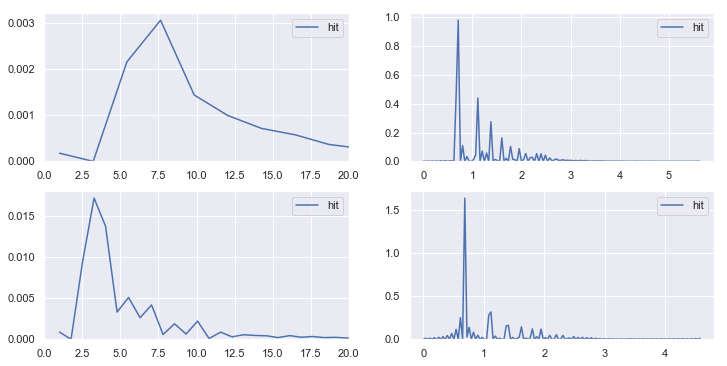

In [755]:
# 取值太多
train_name_col = train['name'].value_counts().reset_index(inplace=False)
train_name_col.columns = ['name', 'hit']
testA_name_col = testA['name'].value_counts().reset_index(inplace=False)
testA_name_col.columns = ['name', 'hit']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(221)
sns.kdeplot(train_name_col['hit'])
plt.xlim(0, 20)
plt.subplot(222)
sns.kdeplot(np.log(train_name_col['hit']))
# plt.xlim(0, 1.5)
plt.subplot(223)
sns.kdeplot(testA_name_col['hit'])
plt.xlim(0, 20)
plt.subplot(224)
sns.kdeplot(np.log(testA_name_col['hit']))
# plt.xlim(0, 1.5)


In [801]:
len(train[train.price>9000])/len(train)

0.20157333333333333

0.1      599.0
0.3     1500.0
0.5     3099.5
0.7     6400.0
0.9    14900.0
Name: price, dtype: float64


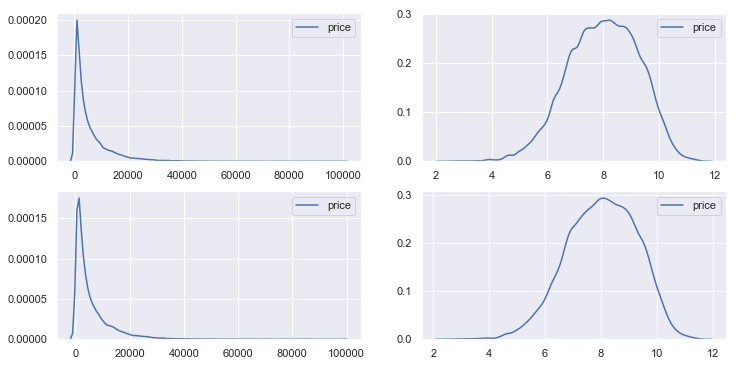

In [841]:
# 取值太多
train_name_price = train[['name', 'price']].groupby(['name']).mean().reset_index(inplace=False)
train_name_price.columns = ['name', 'price']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(221)
sns.kdeplot(train_name_price['price'])
plt.subplot(222)
sns.kdeplot(np.log(train_name_price['price']))


print(np.exp(np.log(train_name_price['price']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))

# test对预测price
testA_name_price = testA[['name', 'price']].groupby(['name']).mean().reset_index(inplace=False)
testA_name_price.columns = ['name', 'price']

plt.subplot(223)
sns.kdeplot(testA_name_price['price'])
plt.subplot(224)
sns.kdeplot(np.log(testA_name_price['price']))

## model列

0.1      36.073218
0.3     123.296757
0.5     220.979637
0.7     431.579203
0.9    1972.680834
Name: hit, dtype: float64


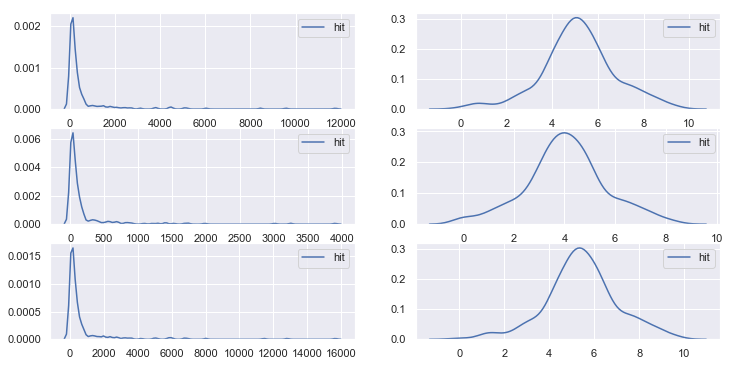

In [842]:
# 取值太多
train_model_hit = train['model'].value_counts().reset_index(inplace=False)
train_model_hit.columns = ['model', 'hit']
testA_model_hit = testA['model'].value_counts().reset_index(inplace=False)
testA_model_hit.columns = ['model', 'hit']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(321)
sns.kdeplot(train_model_hit['hit'])
plt.subplot(322)
sns.kdeplot(np.log(train_model_hit['hit']))
# plt.xlim(0, 1.5)
plt.subplot(323)
sns.kdeplot(testA_model_hit['hit'])
plt.subplot(324)
sns.kdeplot(np.log(testA_model_hit['hit']))
# plt.xlim(0, 1.5)


merge_model_hit = pd.concat([train[['model']], testA[['model']]], ignore_index=True)
merge_model_hit = merge_model_hit.model.value_counts().reset_index(inplace=False)
merge_model_hit.columns = ['model', 'hit']
plt.subplot(325)
sns.kdeplot(merge_model_hit['hit'])
plt.subplot(326)
sns.kdeplot(np.log(merge_model_hit['hit']))

print(np.exp(np.log(merge_model_hit['hit']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))

0.1     1544.539244
0.3     3304.059376
0.5     5396.078304
0.7     8245.995506
0.9    16726.892601
Name: price, dtype: float64


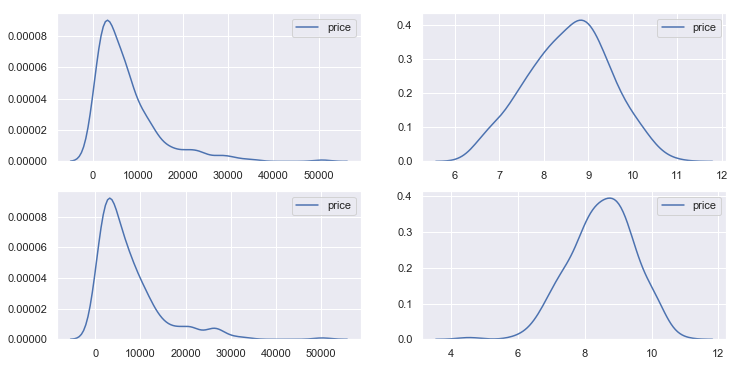

In [843]:
# 取值太多
train_model_price = train[['model', 'price']].groupby(['model']).mean().reset_index(inplace=False)
train_model_price.columns = ['model', 'price']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(221)
sns.kdeplot(train_model_price['price'])
plt.subplot(222)
sns.kdeplot(np.log(train_model_price['price']))


print(np.exp(np.log(train_model_price['price']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))

# test预测price列
testA_model_price = testA[['model', 'price']].groupby(['model']).mean().reset_index(inplace=False)
testA_model_price.columns = ['model', 'price']

plt.subplot(223)
sns.kdeplot(testA_model_price['price'])
plt.subplot(224)
sns.kdeplot(np.log(testA_model_price['price']))



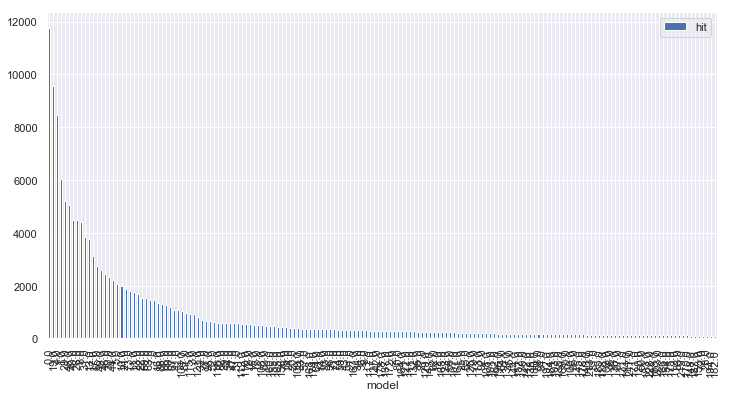

In [120]:
model_col = train['model'].value_counts().reset_index(inplace=False)
model_col.columns = ['model', 'hit']
model_col = model_col.sort_values(['hit'], ascending = False)
model_col.loc[model_col['hit']>100].plot.bar(x="model", y="hit")

## brand列

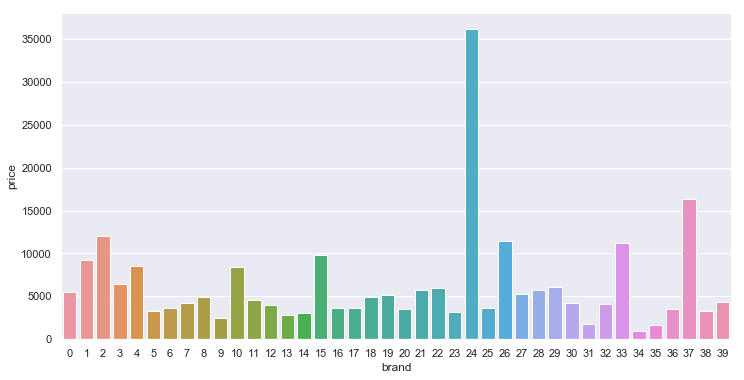

In [121]:
a = train[['brand', 'price']].groupby(['brand']).mean().reset_index()
sns.barplot(x='brand', y= 'price', data=a)

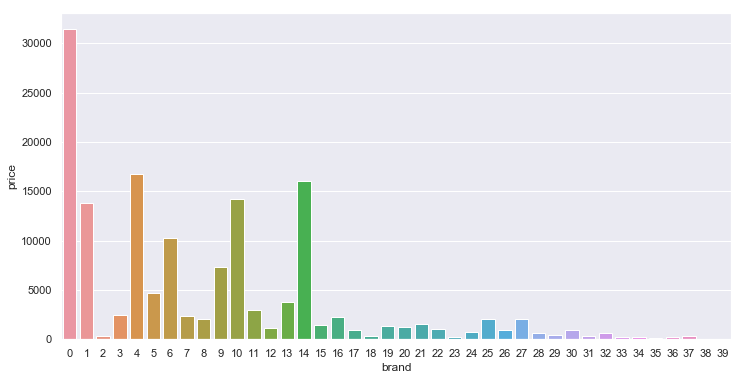

In [122]:
b = train[['brand', 'price']].groupby(['brand']).count().reset_index()
sns.barplot(x='brand', y= 'price', data=b)

0.1      289.039878
0.3      694.959132
0.5     1589.222451
0.7     3041.706848
0.9    18393.761331
Name: hit, dtype: float64


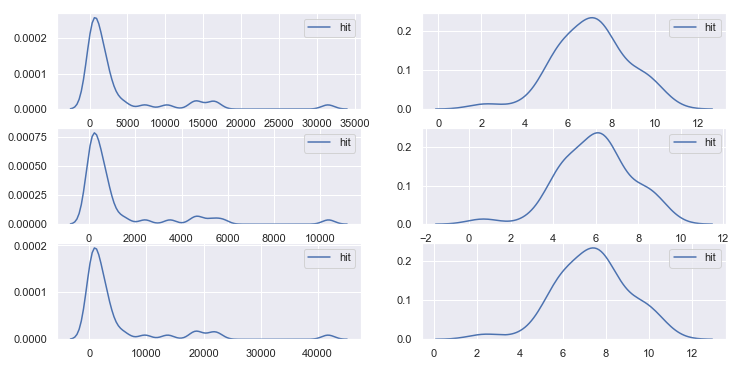

In [844]:
# 取值太多
train_brand_hit = train['brand'].value_counts().reset_index(inplace=False)
train_brand_hit.columns = ['brand', 'hit']
testA_brand_hit = testA['brand'].value_counts().reset_index(inplace=False)
testA_brand_hit.columns = ['brand', 'hit']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(321)
sns.kdeplot(train_brand_hit['hit'])
plt.subplot(322)
sns.kdeplot(np.log(train_brand_hit['hit']))
# plt.xlim(0, 1.5)
plt.subplot(323)
sns.kdeplot(testA_brand_hit['hit'])
plt.subplot(324)
sns.kdeplot(np.log(testA_brand_hit['hit']))
# plt.xlim(0, 1.5)


merge_brand_hit = pd.concat([train[['brand']], testA[['brand']]], ignore_index=True)
merge_brand_hit = merge_brand_hit.brand.value_counts().reset_index(inplace=False)
merge_brand_hit.columns = ['brand', 'hit']
plt.subplot(325)
sns.kdeplot(merge_brand_hit['hit'])
plt.subplot(326)
sns.kdeplot(np.log(merge_brand_hit['hit']))

print(np.exp(np.log(merge_brand_hit['hit']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))

0.1     2761.497192
0.3     3634.633036
0.5     4467.454605
0.7     5867.146540
0.9    11267.491546
Name: price, dtype: float64


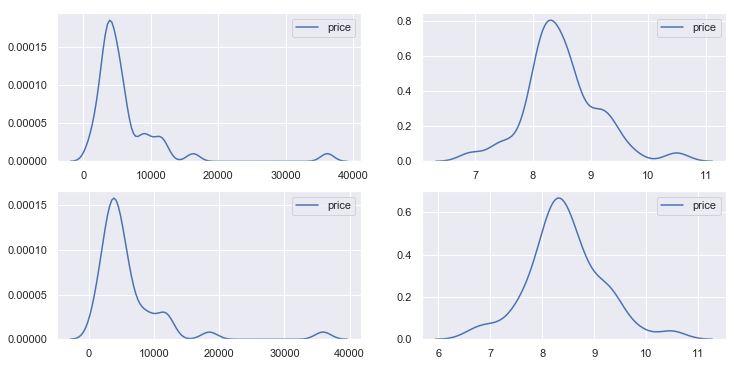

In [845]:
# 取值太多
train_brand_price = train[['brand', 'price']].groupby(['brand']).mean().reset_index(inplace=False)
train_brand_price.columns = ['brand', 'price']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(221)
sns.kdeplot(train_brand_price['price'])
plt.subplot(222)
sns.kdeplot(np.log(train_brand_price['price']))


print(np.exp(np.log(train_brand_price['price']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))


# test预测的price列
testA_brand_price = testA[['brand', 'price']].groupby(['brand']).mean().reset_index(inplace=False)
testA_brand_price.columns = ['brand', 'price']

plt.subplot(223)
sns.kdeplot(testA_brand_price['price'])
plt.subplot(224)
sns.kdeplot(np.log(testA_brand_price['price']))



## bodyType列

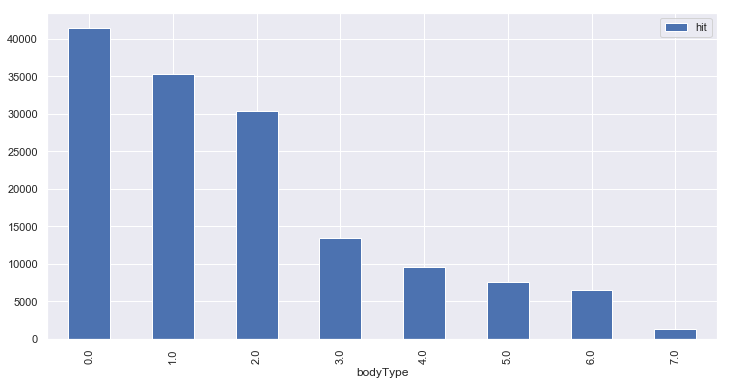

In [125]:
bodyType_col = train['bodyType'].value_counts().reset_index(inplace=False)
bodyType_col.columns = ['bodyType', 'hit']
# bodyType_col = bodyType_col.sort_values(['hit'], ascending = False)
bodyType_col.plot.bar(x="bodyType", y="hit")

## regionCode列

In [126]:
regionCode_col = train['regionCode'].value_counts().reset_index(inplace=False)
regionCode_col.columns = ['regionCode', 'regionCode_count']
regionCode_col

regionCode  regionCode_count
0            419               369
1            764               258
2            125               137
3            176               136
4            462               134
...          ...               ...
7900        6414                 1
7901        7063                 1
7902        4239                 1
7903        5931                 1
7904        7267                 1

[7905 rows x 2 columns]

0.1     3.0
0.3     7.0
0.5    15.0
0.7    30.0
0.9    61.0
Name: hit, dtype: float64


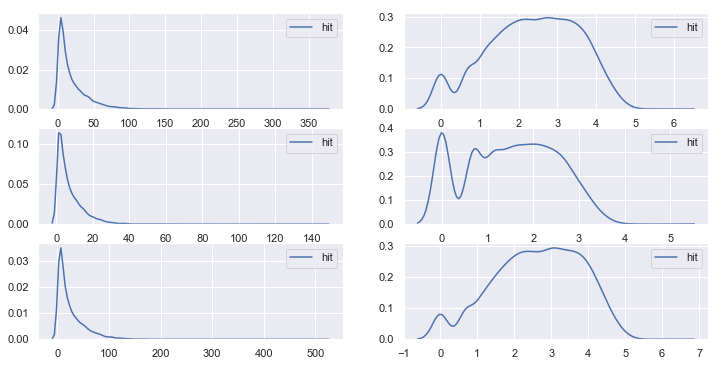

In [846]:
# 取值太多
train_regionCode_hit = train['regionCode'].value_counts().reset_index(inplace=False)
train_regionCode_hit.columns = ['regionCode', 'hit']
testA_regionCode_hit = testA['regionCode'].value_counts().reset_index(inplace=False)
testA_regionCode_hit.columns = ['regionCode', 'hit']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(321)
sns.kdeplot(train_regionCode_hit['hit'])
plt.subplot(322)
sns.kdeplot(np.log(train_regionCode_hit['hit']))
# plt.xlim(0, 1.5)
plt.subplot(323)
sns.kdeplot(testA_regionCode_hit['hit'])
plt.subplot(324)
sns.kdeplot(np.log(testA_regionCode_hit['hit']))
# plt.xlim(0, 1.5)


merge_regionCode_hit = pd.concat([train[['regionCode']], testA[['regionCode']]], ignore_index=True)
merge_regionCode_hit = merge_regionCode_hit.regionCode.value_counts().reset_index(inplace=False)
merge_regionCode_hit.columns = ['regionCode', 'hit']
plt.subplot(325)
sns.kdeplot(merge_regionCode_hit['hit'])
plt.subplot(326)
sns.kdeplot(np.log(merge_regionCode_hit['hit']))

print(np.exp(np.log(merge_regionCode_hit['hit']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))

0.1    2464.057023
0.3    4299.782222
0.5    5423.628571
0.7    6796.571426
0.9    9938.457599
Name: price, dtype: float64


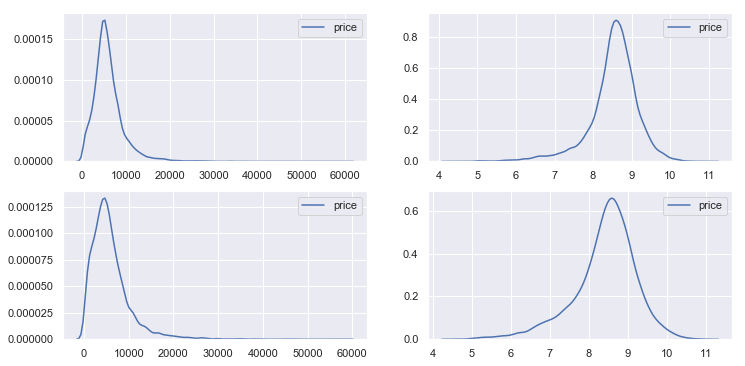

In [847]:
# 取值太多
train_regionCode_price = train[['regionCode', 'price']].groupby(['regionCode']).mean().reset_index(inplace=False)
train_regionCode_price.columns = ['regionCode', 'price']

sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(221)
sns.kdeplot(train_regionCode_price['price'])
plt.subplot(222)
sns.kdeplot(np.log(train_regionCode_price['price']))


print(np.exp(np.log(train_regionCode_price['price']).quantile([0.10, 0.3, 0.5, 0.7, 0.90])))


# test预测的price列
testA_regionCode_price = testA[['regionCode', 'price']].groupby(['regionCode']).mean().reset_index(inplace=False)
testA_regionCode_price.columns = ['regionCode', 'price']

plt.subplot(223)
sns.kdeplot(testA_regionCode_price['price'])
plt.subplot(224)
sns.kdeplot(np.log(testA_regionCode_price['price']))



## 价格分布

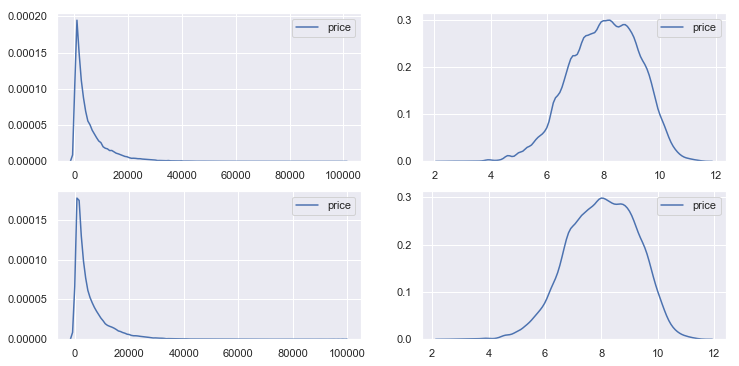

In [200]:
plt.subplot(221)
sns.kdeplot(train['price'])
plt.subplot(222)
sns.kdeplot(np.log(train['price']))
plt.subplot(223)
sns.kdeplot(testA['price'])
plt.subplot(224)
sns.kdeplot(np.log(testA['price']))

## kilometer

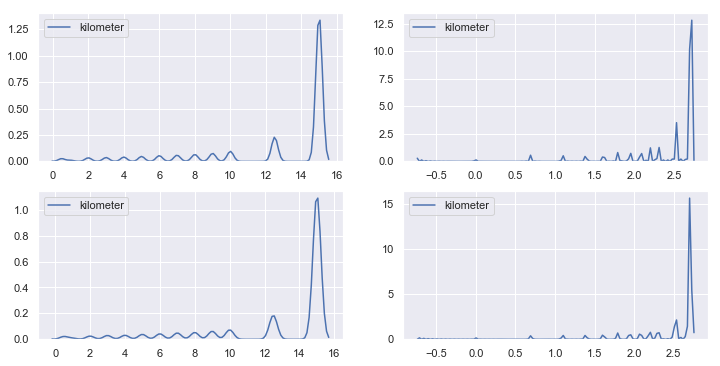

In [130]:
plt.subplot(221)
sns.kdeplot(train['kilometer'])
plt.subplot(222)
sns.kdeplot(np.log(train['kilometer']))
plt.subplot(223)
sns.kdeplot(testA['kilometer'])
plt.subplot(224)
sns.kdeplot(np.log(testA['kilometer']))

## fuelType

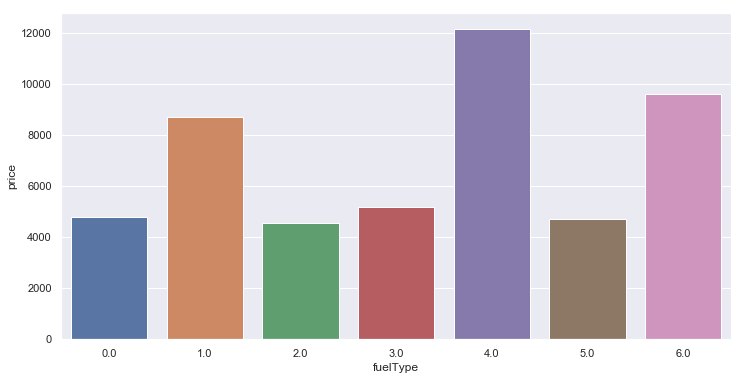

In [131]:
a = train[['fuelType', 'price']].groupby(['fuelType']).mean().reset_index()
sns.barplot(x='fuelType', y= 'price', data=a)

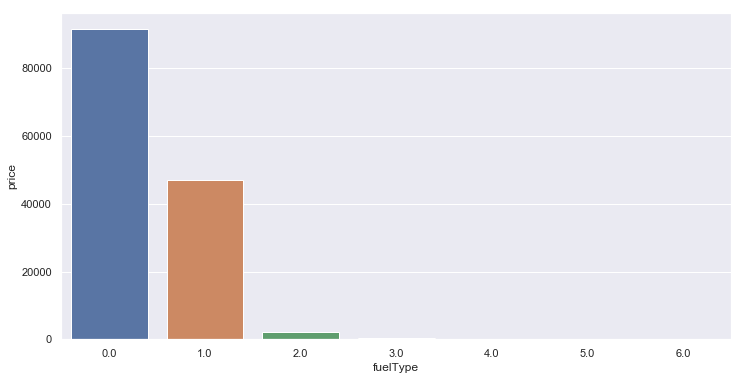

In [132]:
b = train[['fuelType', 'price']].groupby(['fuelType']).count().reset_index()
sns.barplot(x='fuelType', y= 'price', data=b)

## bodyType

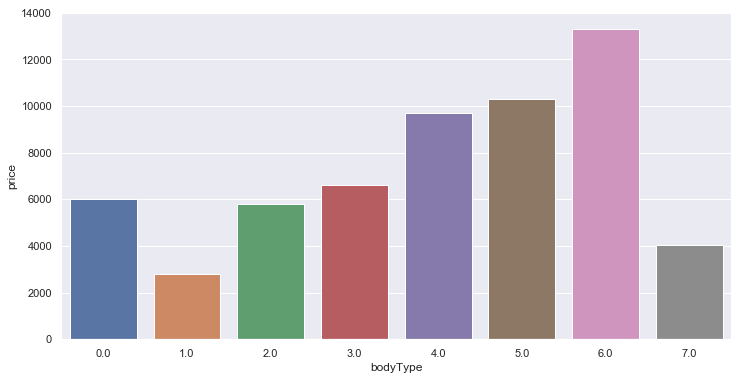

In [133]:
a = train[['bodyType', 'price']].groupby(['bodyType']).mean().reset_index()
sns.barplot(x='bodyType', y= 'price', data=a)

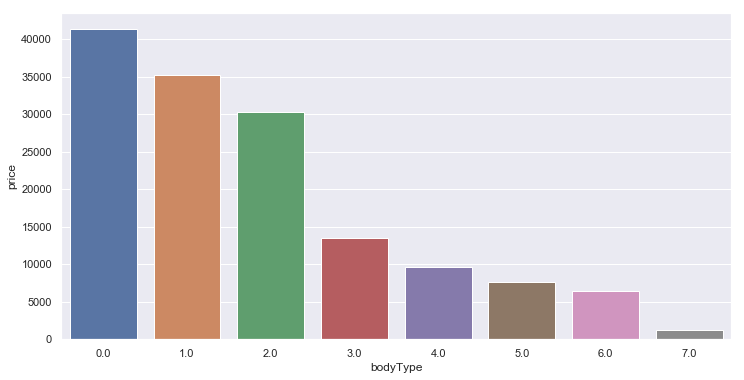

In [134]:
b = train[['bodyType', 'price']].groupby(['bodyType']).count().reset_index()
sns.barplot(x='bodyType', y= 'price', data=b)

## seller

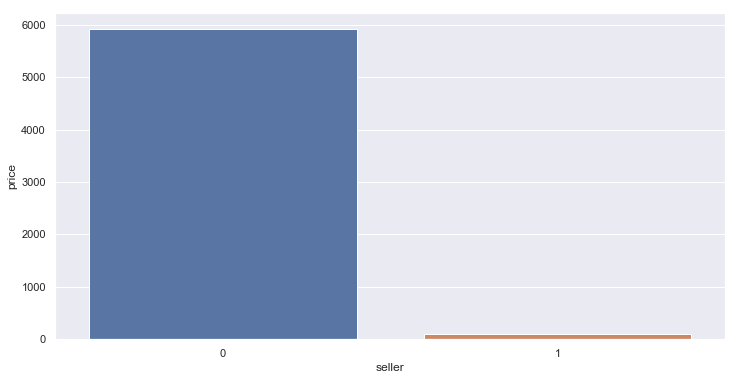

In [135]:
a = train[['seller', 'price']].groupby(['seller']).mean().reset_index()
sns.barplot(x='seller', y= 'price', data=a)

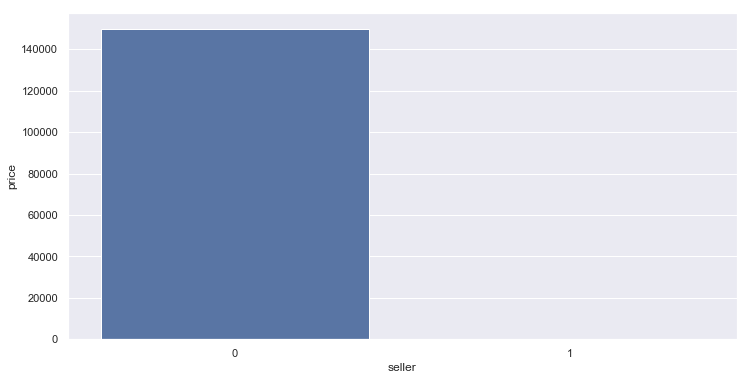

In [136]:
b = train[['seller', 'price']].groupby(['seller']).count().reset_index()
sns.barplot(x='seller', y= 'price', data=b)

## offerType

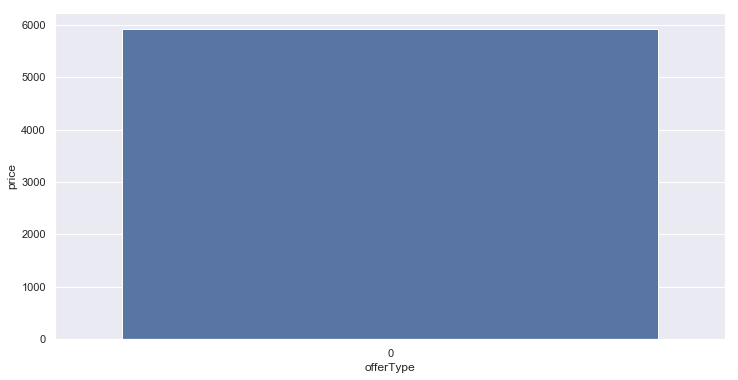

In [137]:
a = train[['offerType', 'price']].groupby(['offerType']).mean().reset_index()
sns.barplot(x='offerType', y= 'price', data=a)

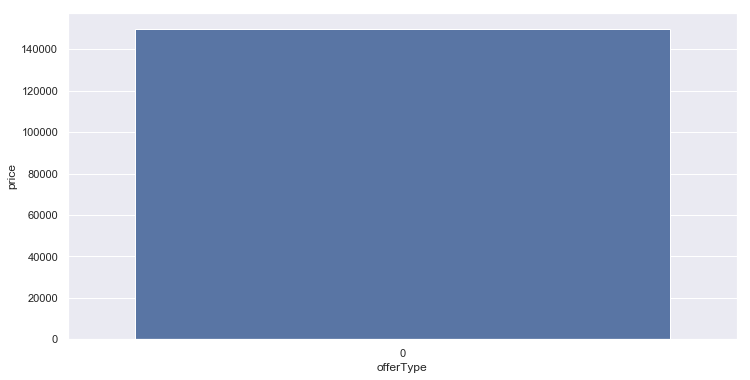

In [138]:
b = train[['offerType', 'price']].groupby(['offerType']).count().reset_index()
sns.barplot(x='offerType', y= 'price', data=b)

## 连续特征与价格可视化

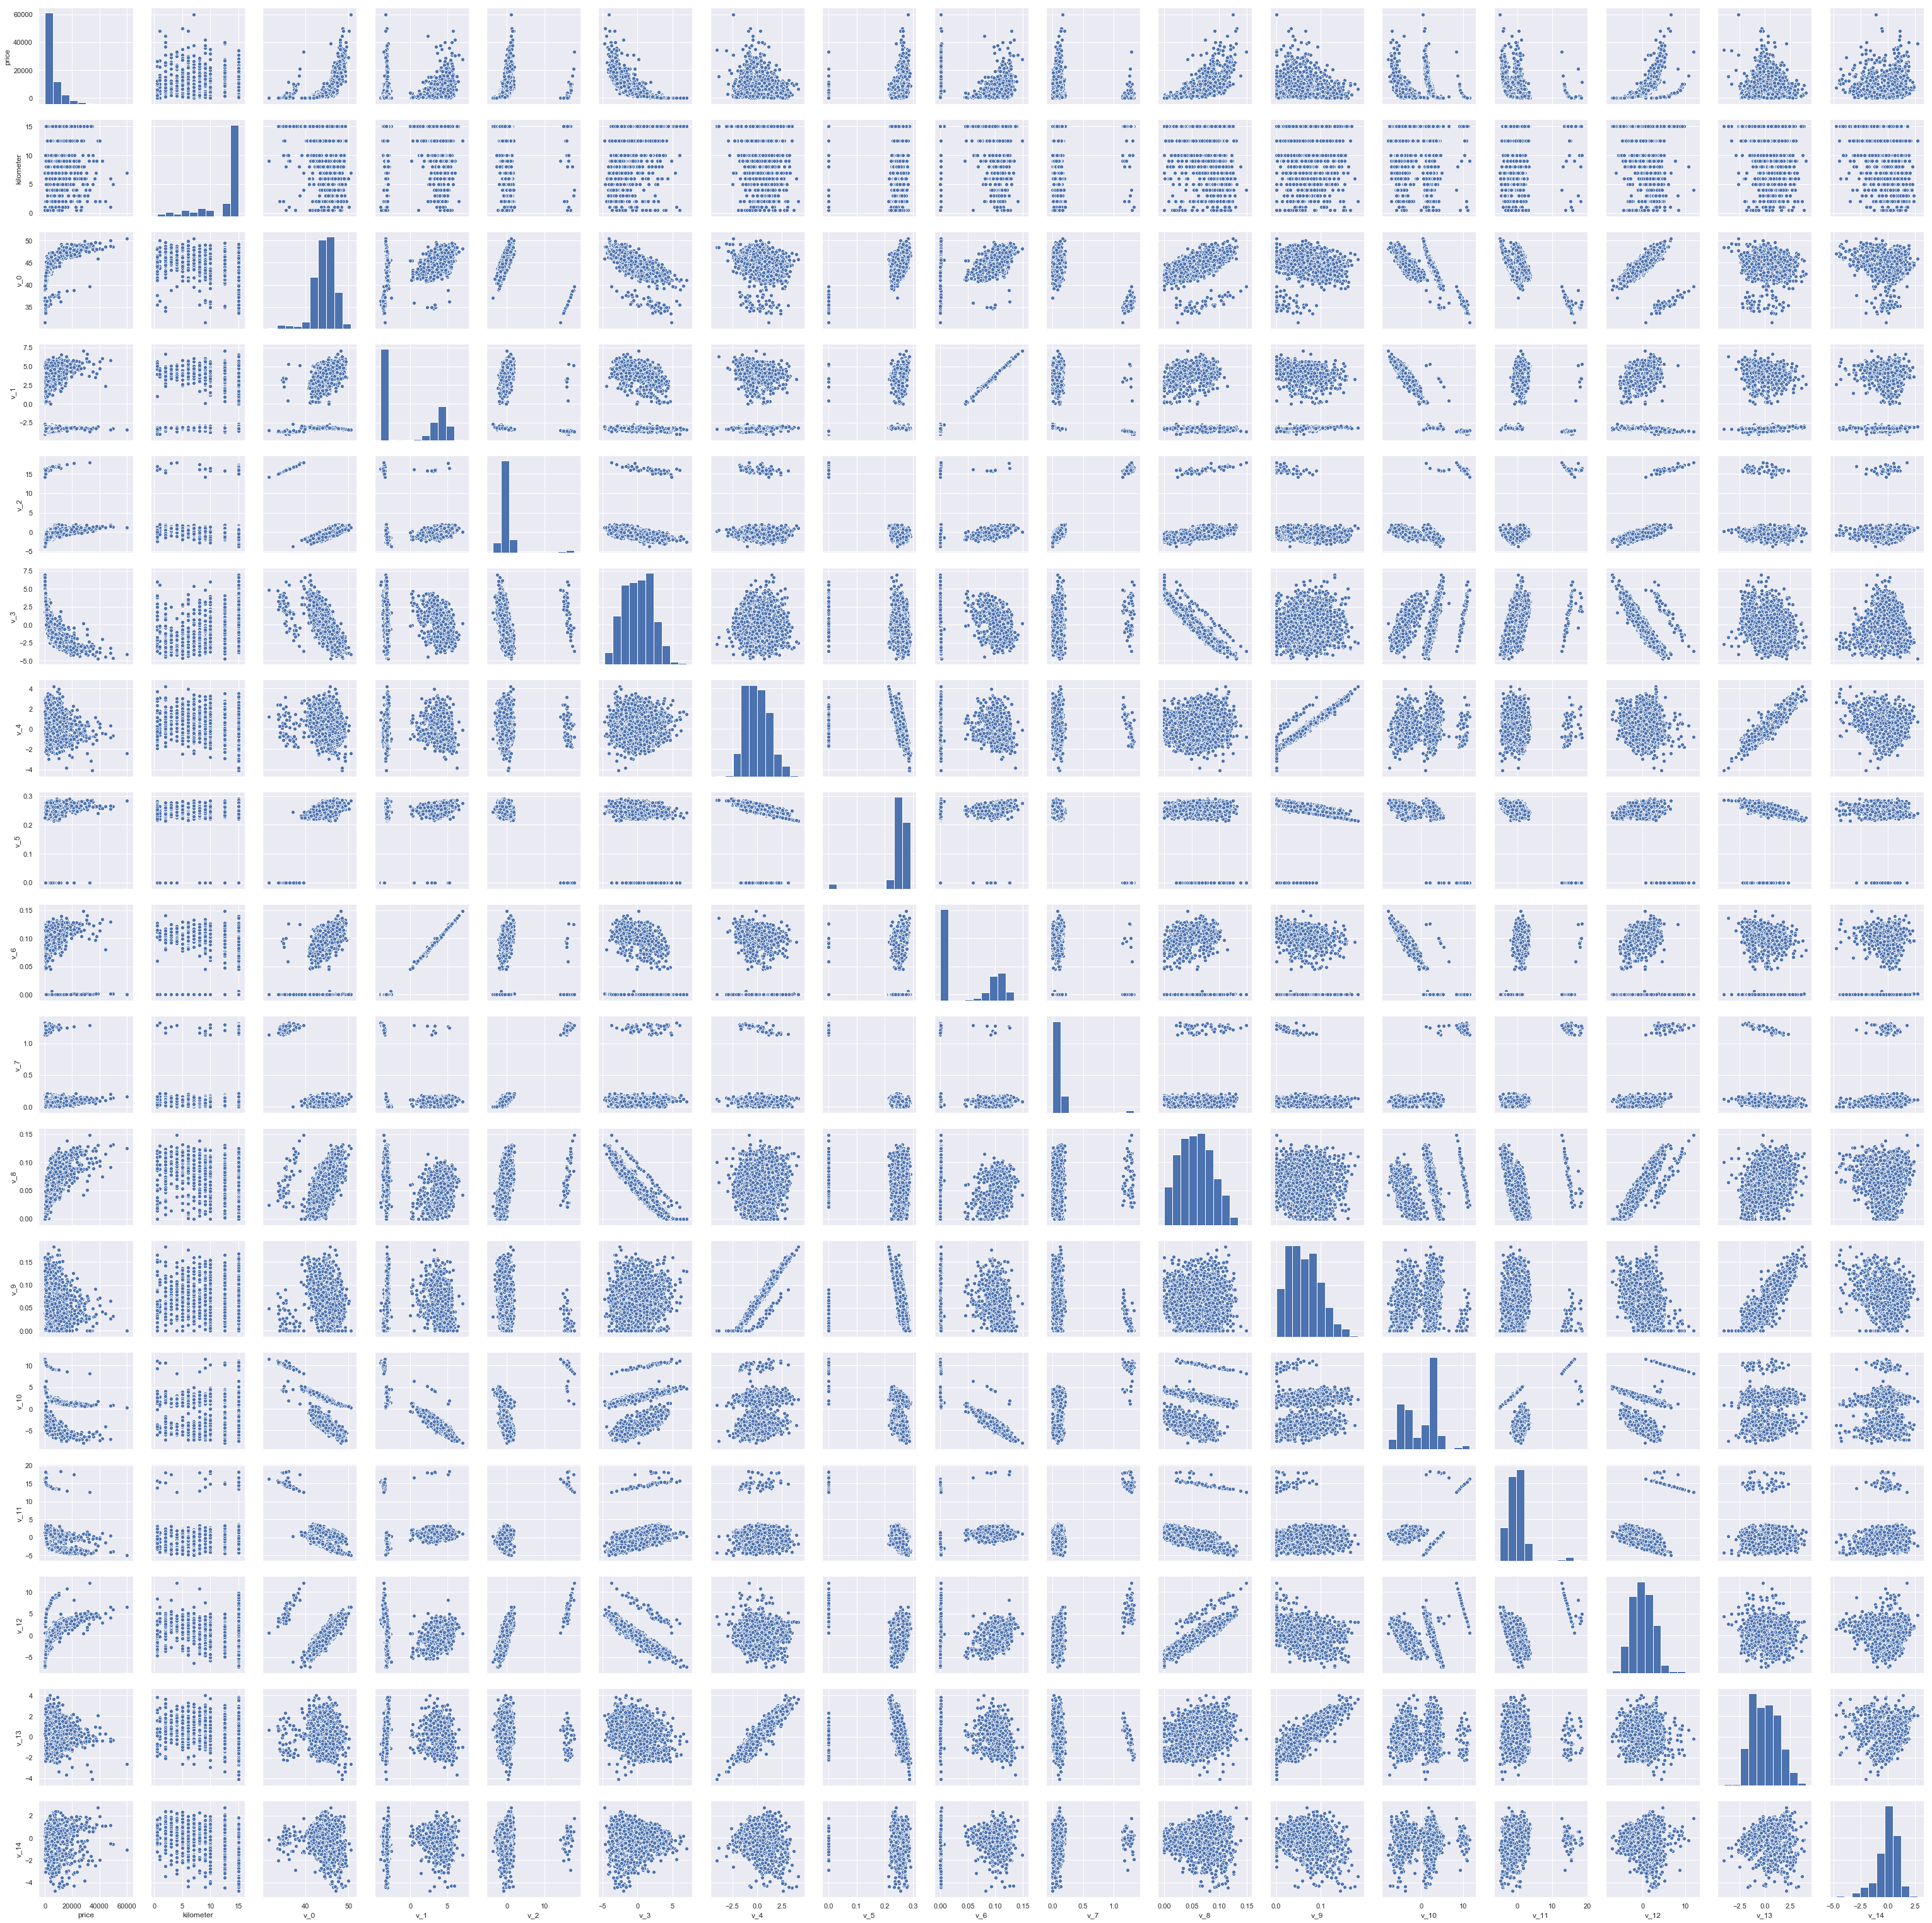

In [27]:
sns.pairplot(data=train.loc[:, ['price', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 
                                'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12','v_13', 'v_14']].sample(n=2000, 
                                                                                                           replace=False, 
                                                                                                           random_state=1234))

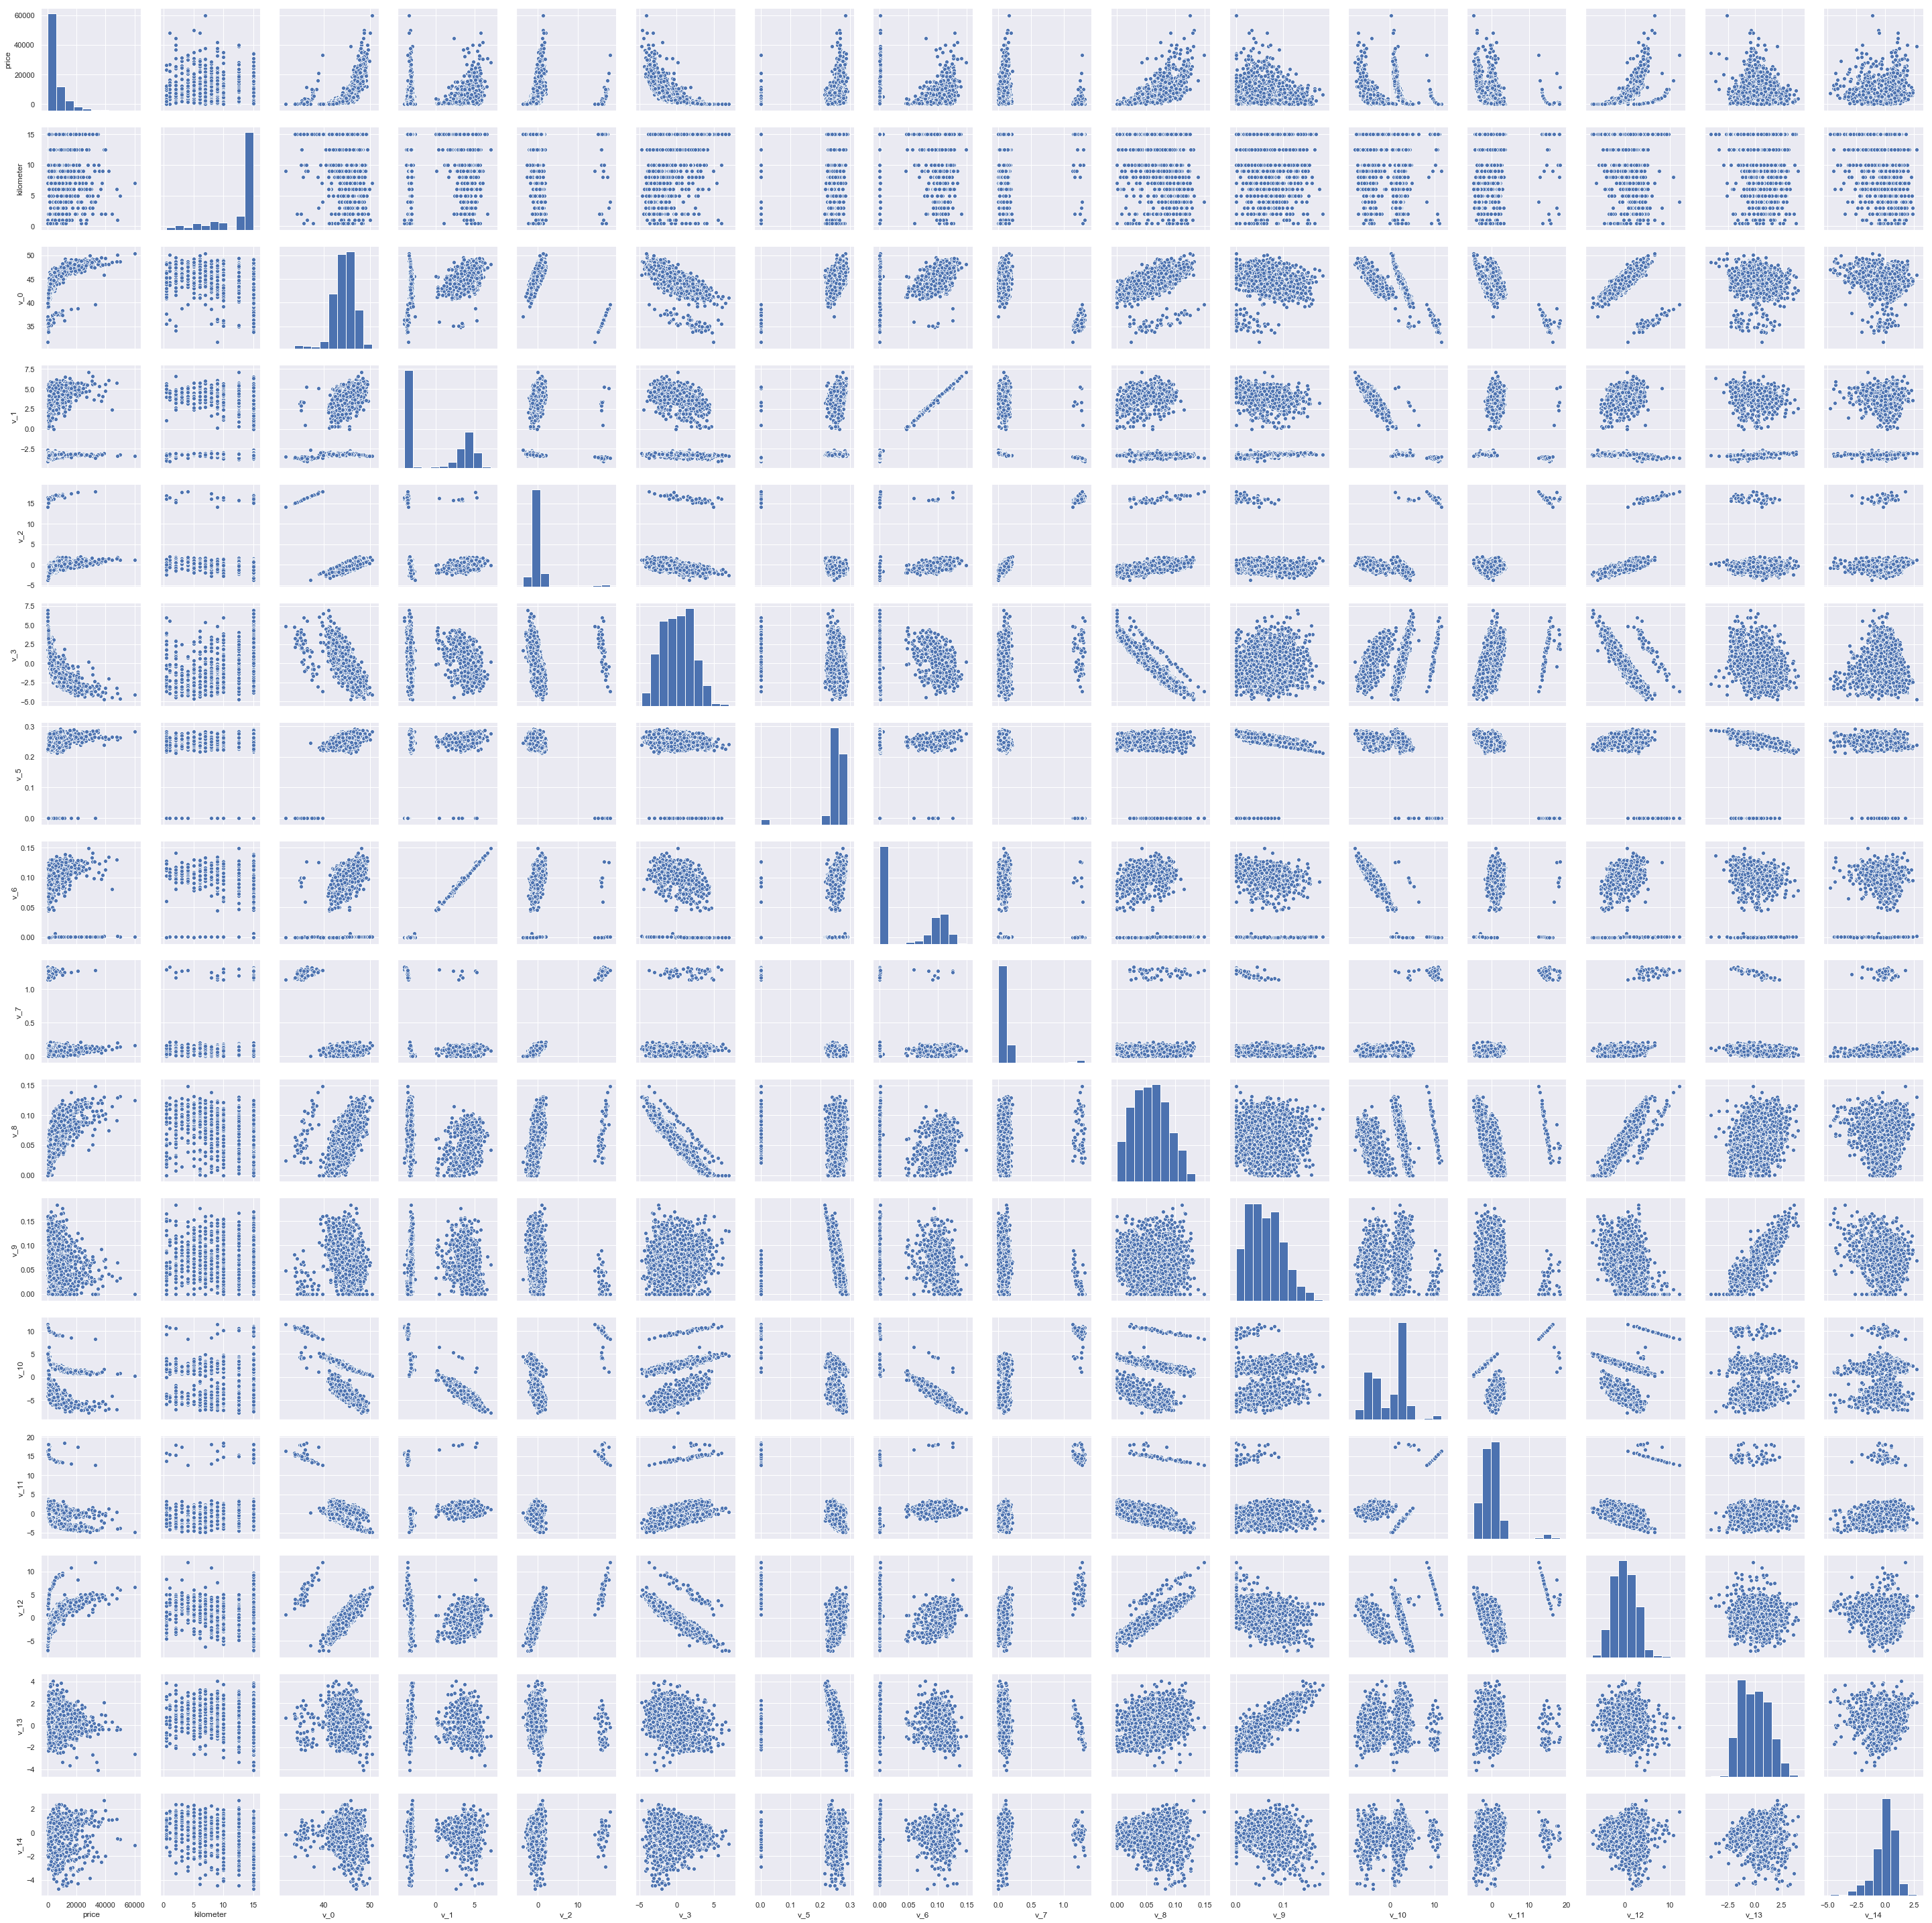

In [30]:
# 去v4
sns.pairplot(data=train.loc[:, ['price', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_5', 
                                'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12','v_13', 'v_14']].sample(n=2000, 
                                                                                                           replace=False, 
                                                                                                           random_state=1234))